# Training Encoder decoder lstm with Method 2

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os

In [7]:
# get data
df= pd.read_csv("../input/eng-mar/cleaned_MAR.csv")

In [8]:
df.tail()

,English,Marathi,en_word_count,mar_word_count,en_char_count,mar_char_count
43066,just saying you dont like fish because of the ...,हड्डींमुळे मासे आवडत नाही असं म्हणणं हे काय मा...,20,13,80,68
43067,the japanese parliament today officially elect...,आज जपानी संसदेने अधिकृतरित्या र्‍यौतारौ हाशिमो...,14,12,87,78
43068,tom tried to sell his old vcr instead of throw...,टॉमने त्याचा जुना व्हीसीआर फेकून टाकण्याऐवजी व...,25,23,89,129
43069,you cant view flash content on an ipad however...,आयपॅडवर फ्लॅश आशय बघता येत नाही पण तुम्ही त्या...,32,24,138,118
43070,in roger miller recorded a song called you do...,मध्ये रॉजर मिलरने यू डोन्ट वॉन्ट माय लव्ह नावा...,34,35,138,149


This data is cleaned in notebook of [EDA](https://github.com/AdiShirsath/Neural-Machine-Translation/blob/master/EDA_And_Cleaning_Text.ipynb)

#### First most important thing is we have to add special tokens in each target language at start SOS and EOS at end reason of this is The length of translated sentence might not be same as other language so it is to tell model where is start and end of sentence.

In [9]:
df.Marathi = df.Marathi.apply(lambda x: 'sos '+ x +' eos')

In [10]:
# get english and marathi in one list
eng_texts = df.English.to_list()
mar_texts = df.Marathi.to_list()

## Tokenizer
Deep learning NN's does not accept text so first have to convert them into numbers 

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

2021-09-12 05:34:29.930526: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [12]:
def tokenize_sent(text):
  '''
  Take list on texts as input and 
  returns its tokenizer and enocded text
  '''
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(text)

  return tokenizer, tokenizer.texts_to_sequences(text)



In [13]:
eng_tokenizer, eng_encoded= tokenize_sent(text= eng_texts)
mar_tokenizer, mar_encoded= tokenize_sent(text= mar_texts)

In [14]:
eng_encoded[100:105]

[[28, 564], [28, 58], [62, 622], [62, 15], [62, 15]]

In [15]:
eng_index_word = eng_tokenizer.index_word

In [16]:
ENG_VOCAB_SIZE = len(eng_tokenizer.word_counts)+1
ENG_VOCAB_SIZE

5795

In [17]:
mar_encoded[30000:30005]

[[1, 22, 65, 386, 1437, 2],
 [1, 25, 65, 386, 2916, 2],
 [1, 22, 65, 386, 1024, 2],
 [1, 486, 3535, 65, 386, 113, 28, 2],
 [1, 25, 65, 386, 1791, 2]]

In [18]:
mar_index_word= mar_tokenizer.index_word

In [19]:
mar_word_index =mar_tokenizer.word_index

In [20]:
MAR_VOCAB_SIZE=len(mar_tokenizer.word_counts)+1
MAR_VOCAB_SIZE

14035

In [21]:
max_eng_len = 0
for i in range(len(eng_encoded)):
  if len(eng_encoded[i]) > max_eng_len:
    max_eng_len= len(eng_encoded[i])

max_mar_len = 0
for i in range(len(mar_encoded)):
  if len(eng_encoded[i]) > max_mar_len:
    max_mar_len= len(mar_encoded[i])


In [22]:
print(max_eng_len)
max_mar_len

34


37

## Padding 
We can not sent sentences with different length in neural net so padd them with zero 

In [23]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [24]:
# Use max length for padding for eng and marathi
eng_padded = pad_sequences(eng_encoded, maxlen=max_eng_len, padding='post')
mar_padded = pad_sequences(mar_encoded, maxlen=max_mar_len, padding='post')


In [25]:
eng_padded.shape

(43071, 34)

In [26]:
mar_padded.shape

(43071, 37)

In [27]:
# Convert them into array
eng_padded= np.array(eng_padded)
mar_padded= np.array(mar_padded)

### Split into train and test

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(eng_padded, mar_padded, test_size=0.1, random_state=0)

In [30]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((38763, 34), (4308, 34), (38763, 37), (4308, 37))

## Model

In [31]:
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding, Bidirectional, Add, Concatenate, Dropout
from tensorflow.keras import Input, Model

In [32]:
# Eoncoder
encoder_input = Input(shape=(None, ))
encoder_embd = Embedding(ENG_VOCAB_SIZE,512, mask_zero=True)(encoder_input)
encoder_lstm = Bidirectional(LSTM(256, return_state=True))
encoder_output, forw_state_h, forw_state_c, back_state_h, back_state_c = encoder_lstm(encoder_embd)
state_h_final = Concatenate()([forw_state_h, back_state_h])
state_c_final = Concatenate()([forw_state_c, back_state_c])

## Now take only states and create context vector
encoder_states= [state_h_final, state_c_final]

# Decoder
decoder_input = Input(shape=(None,))
# For zero padding we have added +1 in marathi vocab size
decoder_embd = Embedding(MAR_VOCAB_SIZE, 512, mask_zero=True)
decoder_embedding= decoder_embd(decoder_input)
# We used bidirectional layer above so we have to double units of this lstm
decoder_lstm = LSTM(512, return_state=True,return_sequences=True )
# just take output of this decoder dont need self states
decoder_outputs, _, _= decoder_lstm(decoder_embedding, initial_state=encoder_states)
# here this is going to predicct so we can add dense layer here
# here we want to convert predicted numbers into probability so use softmax
decoder_dense= Dense(MAR_VOCAB_SIZE, activation='softmax')
# We will again feed predicted output into decoder to predict its next word
decoder_outputs = decoder_dense(decoder_outputs)

model5 = Model([encoder_input, decoder_input], decoder_outputs)

2021-09-12 05:34:36.604868: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-12 05:34:36.607795: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-12 05:34:36.651121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-12 05:34:36.651780: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-12 05:34:36.651872: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-12 05:34:36.683280: I tensorflow/stream_executor/platform/def

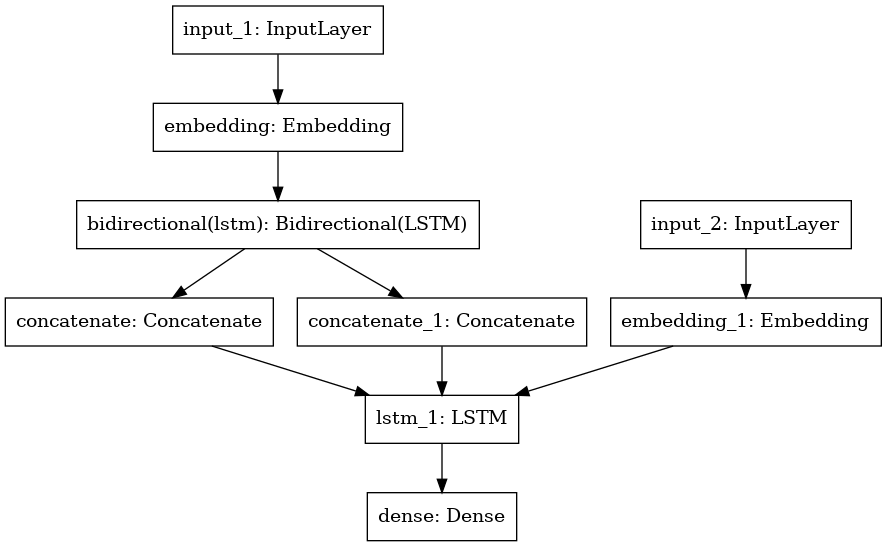

In [33]:
from tensorflow.keras.utils import plot_model
plot_model(model5)

In [34]:
model5.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 512)    2967040     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 512), (None, 1574912     embedding[0][0]                  
______________________________________________________________________________________________

In [35]:
y_train

array([[   1,   10,  266, ...,    0,    0,    0],
       [   1, 3071,  458, ...,    0,    0,    0],
       [   1,   96,  245, ...,    0,    0,    0],
       ...,
       [   1, 1500,  497, ...,    0,    0,    0],
       [   1,  208,  165, ...,    0,    0,    0],
       [   1,   85,  489, ...,    0,    0,    0]], dtype=int32)

In [36]:
model5.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 512)    2967040     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 512), (None, 1574912     embedding[0][0]                  
______________________________________________________________________________________________

In [37]:
model5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### Callbacks

In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("./model5/", monitor='val_accuracy')

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

callbacks_list = [checkpoint, early_stopping]

In [42]:
EPOCHS= 30 #@param {type:'slider',min:10,max:100, step:10 }

### Prepare input for encoder -decoder model

In [43]:
# Training
encoder_input_data = X_train
decoder_input_data = y_train[:,:-1]
decoder_target_data = y_train[:,1:]

# Testing
encoder_input_test = X_test
decoder_input_test = y_test[:,:-1]
decoder_target_test= y_test[:,1:]

In [44]:
history = model5.fit([encoder_input_data, decoder_input_data],decoder_target_data, 
                    epochs=EPOCHS, 
                    batch_size=128,
                    validation_data = ([encoder_input_test, decoder_input_test],decoder_target_test ),
                     callbacks= callbacks_list)

2021-09-12 05:35:20.685980: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-12 05:35:20.695761: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000134999 Hz


Epoch 1/30


2021-09-12 05:35:28.842710: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-12 05:35:29.659376: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-12 05:35:29.953174: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


303/303 [==============================] - 77s 204ms/step - loss: 1.1170 - accuracy: 0.2697 - val_loss: 0.7890 - val_accuracy: 0.3821


2021-09-12 05:36:48.317774: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/30
303/303 [==============================] - 58s 192ms/step - loss: 0.7300 - accuracy: 0.4074 - val_loss: 0.6155 - val_accuracy: 0.4847
Epoch 3/30
303/303 [==============================] - 58s 192ms/step - loss: 0.5280 - accuracy: 0.5151 - val_loss: 0.4930 - val_accuracy: 0.5586
Epoch 4/30
303/303 [==============================] - 57s 188ms/step - loss: 0.3716 - accuracy: 0.6076 - val_loss: 0.4191 - val_accuracy: 0.6103
Epoch 5/30
303/303 [==============================] - 56s 185ms/step - loss: 0.2652 - accuracy: 0.6902 - val_loss: 0.3751 - val_accuracy: 0.6471
Epoch 6/30
303/303 [==============================] - 56s 183ms/step - loss: 0.1871 - accuracy: 0.7649 - val_loss: 0.3503 - val_accuracy: 0.6715
Epoch 7/30
303/303 [==============================] - 56s 185ms/step - loss: 0.1365 - accuracy: 0.8196 - val_loss: 0.3360 - val_accuracy: 0.6903
Epoch 8/30
303/303 [==============================] - 55s 183ms/step - loss: 0.1047 - accuracy: 0.8560 - val_loss: 0.3265 - val_ac

In [45]:
model5.save_weights("./model-enocder-decoder_method2.h5")

# inference Model

In [46]:
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding
from tensorflow.keras import Input, Model

In [47]:
encoder_model = Model(encoder_input, encoder_states)

In [48]:
decoder_state_input_h = Input(shape=(512,))
decoder_state_input_c= Input(shape=(512,))
decoder_states_input= [decoder_state_input_h, decoder_state_input_c]

dec_embd2 = decoder_embd(decoder_input)

decoder_output2,state_h2, state_c2 = decoder_lstm(dec_embd2, initial_state=decoder_states_input)
deccoder_states2= [state_h2, state_c2]

decoder_output2 = decoder_dense(decoder_output2)

decoder_model = Model(
                      [decoder_input]+decoder_states_input,
                      [decoder_output2]+ deccoder_states2)

#### Converting predicted numbers into text

In [49]:
def get_predicted_sentence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = mar_word_index['sos']
    
    # Sampling loop for a batch of sequences

    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index==0:
          break
        else:   
         # convert max index number to marathi word
         sampled_char = mar_index_word[sampled_token_index]
        # aapend it ti decoded sent
        decoded_sentence += ' '+sampled_char
        
        # Exit condition: either hit max length or find stop token.
        if (sampled_char == 'eos' or len(decoded_sentence) >= 37):
            stop_condition = True
        
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # Update states
        states_value = [h, c]
    
    return decoded_sentence

In [50]:
def get_marathi_sentence(sequence):
  sentence=""
  for i in sequence:
    if ((i != 0 and i != mar_word_index['sos']) and i != mar_word_index['eos']):
      sentence = sentence + mar_index_word[i]+' '
  return sentence

def get_eng_sent(sequence):
    sentence =''
    for i in sequence:
      if(i!=0):
        sentence = sentence + eng_index_word[i]+' '
    return sentence       

In [51]:
for i in range(20):
  print("English sentence:",get_eng_sent(X_test[i]))
  print("Actual Marathi Sentence:",get_marathi_sentence(y_test[i]))
  print("Translated Marathi Sentence:",get_predicted_sentence(X_test[i].reshape(1,36))[:-4])
  print("\n")

English sentence: i dont have what i want 
Actual Marathi Sentence: मला जे हवं आहे ते माझ्याकडे नाहीये 


ValueError: cannot reshape array of size 34 into shape (1,36)